In [15]:
from IPython.core.display import HTML
def css_styling():
    styles = open("./custom.css", "r").read()
    return HTML(styles)
css_styling()

In [16]:
import acoular as ac
import numpy as np
import matplotlib.pyplot as plt
import os

<img src="img/DAGA_logo.png" alt="DAGA Logo" style="width:160px; position:absolute; top:20px; right:0px;">
<img src="img/TU-lang.png" alt="TU Logo" style="width:230px; position:absolute; top:0px; right:180px;">

<h1 style="margin-top: 180px; margin-bottom: 50px; color: #A81D1E;">Acoustic Data Acquisition and Processing in Python using a MEMS Microphone Array</h1>
<h3 style="margin-top: 50px; margin-bottom: 50px; color: #434343;">Rabea Eschenhagen, Adam Kujawski, Art J. R. Pelling, Mikolaj Czuchaj, Gert Herold, Oliver Lylloff, Ennes Sarradj</h3>

<h5 style="margin-top: 50px; margin-bottom: 100px; color: #434343;">Jupyter Notebook available at <a href="https://github.com/acoular/workshop_DAS-DAGA-2025">https://github.com/acoular/workshop_DAS-DAGA-2025</a></h5>


## What we will do

- Stream and process live audio data from laptop’s microphone
- Revisit a simple beamforming example with microphone array data
- Demonstration of an application that brings together the discussed concepts
- _Bonus:_ Implement a real-time visualization of frequency components


## Getting data from input channels

### Sounddevice library
- current environment must include the `sounddevice` library
- first check the available audio devices on the system.

In [ ]:
import sounddevice as sd

sd.query_devices() 

### Set index of the desired audio device

In [12]:
device_number = None #TODO: Set the device number here

###  Acoular's streaming method

- `SoundDeviceSamplesGenerator` class handles audio data streams
- Uses the sounddevice library internally
- Requires setting the device index to choose the audio interface
- Configuration for single-channel acquisition (numchannels=1)

In [ ]:
dev = ac.SoundDeviceSamplesGenerator(
    device = device_number,
    numchannels = 1,
)

print("Sampling frequency: ", dev.sample_freq)

### Transforming  voltages into sound pressure 

- Recorded signal is in volts and needs conversion to sound pressure (Pa)
- Sensitivity defines voltage output per unit of sound pressure
- Conversion is done by multiplying with the reciprocal of sensitivity
- _Example: 0.016 V/Pa means 1 Pa corresponds to 0.016 V_


In [11]:
dev_calibrated = ac.Calib(source=dev, data=1/0.016*np.ones(dev.num_channels))

### Recording a signal

- Acquire a signal with a duration of 2 seconds
- Read input stream block by block (block size: 256 samples)
- Use `return_result` to retrieve all blocks at once
- `SoundDeviceSamplesGenerator` prints device properties when streaming starts
- Array `t`: first axis is time data, second axis is number of channels

In [ ]:
recording_time = 2 # seconds 
dev.num_samples = int(recording_time * dev.sample_freq)

signal = ac.tools.return_result(dev_calibrated, num=256)
t = np.arange(signal.shape[0]) / dev.sample_freq 

### Plot of results


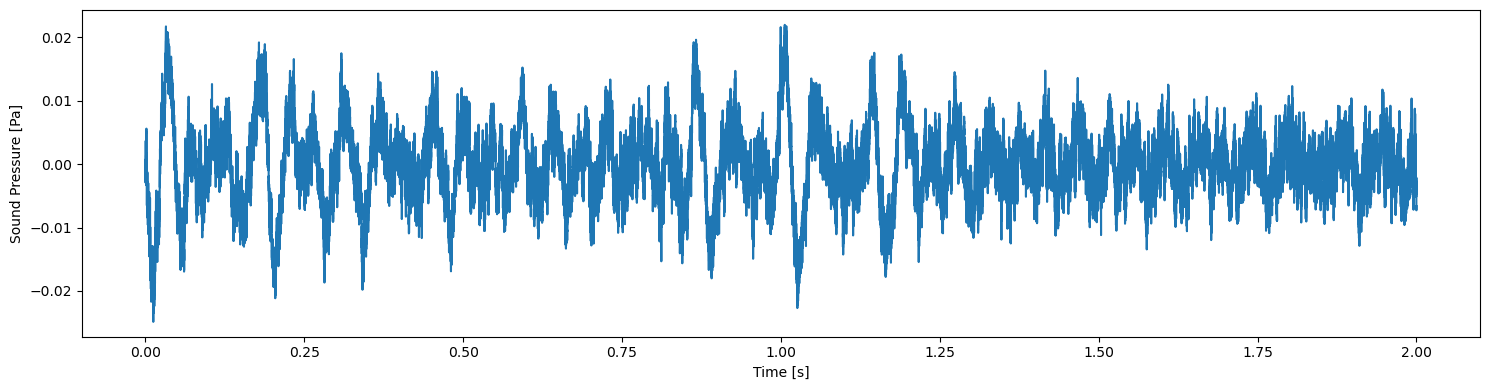

In [7]:
plt.figure(figsize=(15,4))
plt.plot(t, signal[:,0])
plt.ylabel('Sound Pressure [Pa]')
plt.xlabel('Time [s]')
plt.tight_layout()
plt.show()

## Writing measurement data to disk

### Further Processing

- Acoular allows additional processing steps beyond acquiring time data
- Processing is handled via classes from the `tprocess.py` module
- `WriteH5` class saves the full stream to an HDF5 file
- Alternatively, `WriteWav` can be used to save the stream as a WAV file

In [8]:
hdf5 = ac.WriteH5(
    source = dev_calibrated,
    file = 'sounddevice.h5',
)

### Save to disk
- Two processing chains were created to read data from `dev` (`SoundeDeviceSamplesGenerator`)
- Data can either be passed on or saved to disk
- Due to lazy evaluation, no processing has occurred yet
- Two ways to start acquisition and writing:

    1. `hdf5.result(num=256)`: Generates data block-wise
    2. `hdf5.save()`: Runs the processing chain in one go, without returning data
- Option 2 is used

In [ ]:
hdf5.save()

### Read file

- File can be processed with any software supporting this format
- Use the `TimeSamples` object to read the data for further post-processing

In [ ]:
ts = ac.TimeSamples(file='sounddevice.h5')

print("Number of channels: ", ts.num_channels, "; Number of samples: ", ts.num_samples)

## Microphone array data processing

### Set up input device parameters
- Set up input device parameters for recording.
- A 16-channel low-cost microphone array was used for recording
- `SoundDeviceSamplesGenerator` initialized with:
    - `device = 0`
    - `numchannels = 16`
- Recording duration: 4 seconds.
- Multichannel data saved in `img/multichannel_signal.h5`

In [ ]:
time_data = ac.MaskedTimeSamples(file='img/multichannel_signal.h5')

print("Number of channels: ", time_data.num_channels, "; Number of samples: ", time_data.num_samples)

### Define the microphone geometry and the computational grid
-   Microphone array geometry is loaded from an XML file

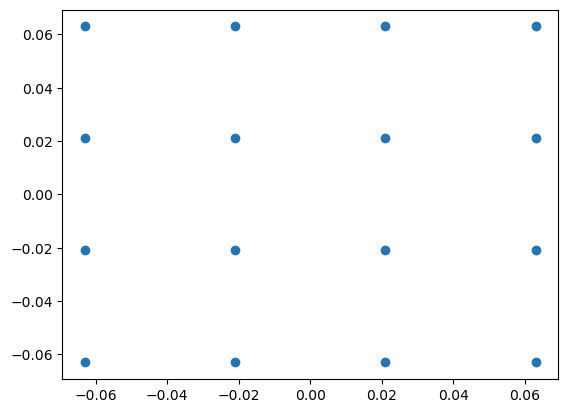

In [12]:
mics = ac.MicGeom(file=ac.__path__[0] + '/xml/minidsp_uma-16_mirrored.xml')

# Plot of microphone positions
plt.scatter(*mics.pos[:2])
plt.show()

### Define a rectangular grid 
- Specifies the search region for sound sources
- Covers the spatial range with a resolution of 0.05 m

In [13]:
x_min, x_max = -1.2, 1.2
y_min, y_max = -1.2, 1.2
z = 1.54
increment = 0.05

grid = ac.RectGrid(                 # for 3D Grid use ac.RectGrid3D and set z_min and z_max
    x_min=x_min, x_max=x_max, 
    y_min=y_min, y_max=y_max, 
    z=z, 
    increment=increment
)

### Define the steering vector for beamforming

- Set the speed of sound in air
- Create a steering vector using microphone geometry and defined rectangular grid

In [14]:
c = 346 # speed of sound
steer = ac.SteeringVector(mics=mics, env=ac.Environment(c=c), grid=grid)

### Setup Beamforming
- Transform recorded time-domain signal into the frequency domain
- Apply Hanning window with 50% overlap
- Use a block size of 128 samples
- `BeamformerBase` performs beamforming using the delay-and-sum algorithm

In [15]:
freq_data = ac.PowerSpectra(source=time_data, window='Hanning', overlap='50%', block_size=128)
bb = ac.BeamformerBase(freq_data=freq_data, steer=steer)

### Apply beamforming 
- _Example_: Use third-octave frequency band centered at 4000 Hz
- Convert raw beamforming output to sound pressure levels (SPL) in decibels

In [16]:
frequency = 4000 
result = bb.synthetic(frequency, num=3)
Lm = ac.L_p(result)
Lm_reshaped = Lm.reshape(grid.shape) # converting 1D array to 2D array

### Plot of beamforming results 
- Overlay results onto a background image
- Heatmap represents sound pressure levels (SPL) in decibels
- SPL values are mapped to image coordinates

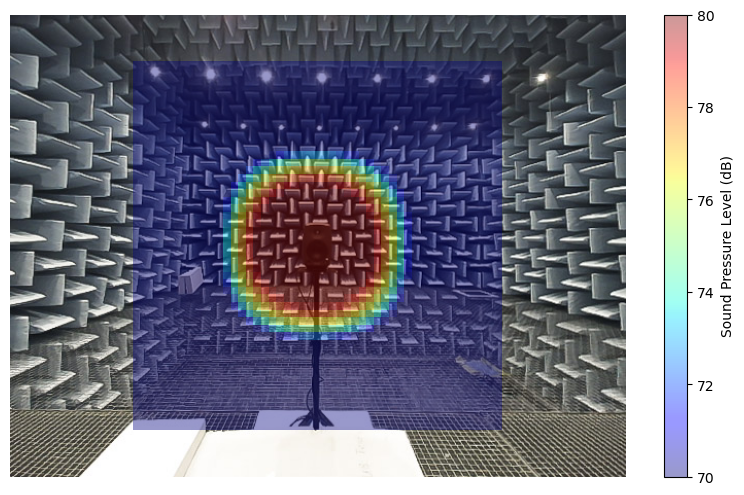

In [17]:
fig, ax = plt.subplots(figsize=(10, 6))

# Background image 
background_img = plt.imread("multichannel_signal.jpg") 
im_w, im_h = background_img.shape[1], background_img.shape[0] 
ax.imshow(background_img, extent=[0, im_w, 0, im_h])

# Pixel indices of Beamforming plot in photo for correct placing
p_ind = lambda img, v: (img / 2 + 230 * (v / z)) 

# Beamforming plot
heatmap = ax.imshow(
    Lm_reshaped, extent=[p_ind(im_w, x_min), p_ind(im_w, x_max), p_ind(im_h, y_min), p_ind(im_h, y_max)], 
    origin='lower', cmap='jet', alpha=0.4, vmin=70, vmax=80
)

cbar = fig.colorbar(heatmap, ax=ax)
cbar.set_label("Sound Pressure Level (dB)")

ax.set_xlim([0, im_w])
ax.set_ylim([0, im_h])

ax.axis('off')
plt.show()

## SpectAcoular!
### What it is
- Extension for Acoular
- Designed for microphone array data acquisition, analysis, and exploration
- Provides interactive tools for real-time beamforming and signal processing
- Uses [_Bokeh_](https://bokeh.org/) for web-based visualization, allowing client-server applications
- Implements graphical controls (widgets) for user interaction

### Why to use it
- Easy and interactive microphone array data processing
- Enables real-time signal exploration and beamforming analysis
- Allows users to analyze sound sources in real time
- Customizable and expandable for different applications

### Where to find it
- **GitHub:** [SpectAcoular Repository](https://github.com/acoular/spectacoular)
- **Anaconda:** [SpectAcoular Package](https://anaconda.org/acoular/spectacoular)
- **Documentation:** [SpectAcoular Docs](https://acoular.github.io/spectacoular)


In [ ]:
os.popen('msm_app --port==5507 --args --device=sounddevice')

## Bonus: Create a simple real-time processing plot
- Process live audio data from your laptop’s microphone
- Create a live plot of a frequency spectrum
- Use threading to enable parallel processing
- You may need to install _Plotly_ and _ipywidgets_


    To install the required libraries using pip, run:

    `pip install plotly ipython jupyterlab ipywidgets`


    Alternatively, if you're using Conda, install them with:


    `conda install -c conda-forge plotly ipython jupyterlab ipywidgets`


    If you experience issues with interactive plots in Jupyter, try enabling the widgets extension:

    `jupyter nbextension enable --py widgetsnbextension`


In [13]:
# Additional Imports
import threading 
import plotly.graph_objects as go # create live plots
from IPython.display import display
import time

- Continue working with `dev_calibrated` from the first section
- Perform a series of processing steps on the data stream
- Transform time-domain signals into the frequency domain with `RFFT`
- `fft.fftfreq()` retrieves the frequency values corresponding to the FFT bins

In [19]:
fft = ac.RFFT(source=dev_calibrated, block_size=256) # one-sided Fast Fourier Transform (FFT)
fft_generator = fft.result(num=1)
freqs = fft.fftfreq()

- `update_plot` function runs in a separate thread
  - Continuously updates a live FFT plot
  - Retrieves real-time frequency data from `fft_generator`
  - Dynamically updates the figure to reflect incoming data

In [20]:
def update_plot(dev, fft_generator, freqs, fig):
    print("Starting live plot...")

    while dev.collect_samples:
        try:
            fft_data = next(fft_generator) 
            
            # Power spectral density
            fft_power = np.abs(fft_data).flatten()**2 

            #  Sound pressure level 
            fft_db = ac.L_p(fft_power)

            with fig.batch_update():
                fig.data[0].x = freqs
                fig.data[0].y = fft_db

        except StopIteration:
            break
    
    print("Live plot stopped.")

- Initialize the real-time audio processing pipeline
- `fft.result(num=1)` creates a generator that yields FFT blocks
- Each block has a size of $block\_size / 2 + 1$, representing positive frequency components
- Processing runs for 5 seconds before shutting down

In [ ]:
fig = go.FigureWidget()
fig.add_trace(go.Bar(x=[], y=[], marker_color='#0C3762')) 

fig.update_layout(
    title="Live Spectrum",
    xaxis_title="Frequency (Hz)",
    yaxis_title="",
    xaxis_range=[0, 4000], 
    yaxis_range=[0, 120],
    bargap=0.4
)

display(fig)

dev.collect_samples = True 
fft_generator = fft.result(num=1)

plot_thread = threading.Thread(target=update_plot, args=(dev, fft_generator, freqs, fig))
plot_thread.start()

time.sleep(5)

dev.collect_samples = False 
plot_thread.join()